# Homework 3: work with your data using Numpy and Scipy

In this Notebook, you will need to:
- Convert your data (loaded in HW2) into a Numpy array;
- Get and visualize a correct periodogram of your data;
- Choose and apply a filter to remove specified frequencies;
- Apply ICA on your data.

**Note:** you will be able to use the results from this work in your project document (when describing the data you worked with).

In [1]:
from scipy import signal
from scipy.io import loadmat
from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import FastICA
from datetime import datetime

## Load your data

In [2]:
raw = loadmat('S1_run10.mat')[ 'y' ].transpose()
raw.shape

(134788, 258)

## Convert it to Numpy (if not already a Numpy array)

- For a Pandas DataFrame, it should be as simple as `df.to_numpy()`
- For an MNE RawArray object, `x.get_data()` should work (where `x` is the name of your loaded data object). 

Ensure that your Numpy array contains correct number of channels and samples, and that it does not contain empty values.
- If your data file contains several pieces of recordings with spaces between them, keep only one recording, as it should be continuous.

In [3]:
sample_rate = 600
timepoints = raw[ :, 0 ]
events = raw[ :, -1 ]
data = raw[ :, 1:(-1) ]
data.shape

(134788, 256)

In [4]:
assert round(raw.shape[ 0 ] / sample_rate) == round(timepoints[ -1 ])
round(timepoints[ -1 ], 2)  # Measurement length (s)

224.64

## Calculate and visualize a periodogram of your data

Use relevant Scipy and Matplotlib functions. Label plot axes.
- If you need, you can produce several plots; e.g. on a second plot you can limit an axis to zoom in some details.

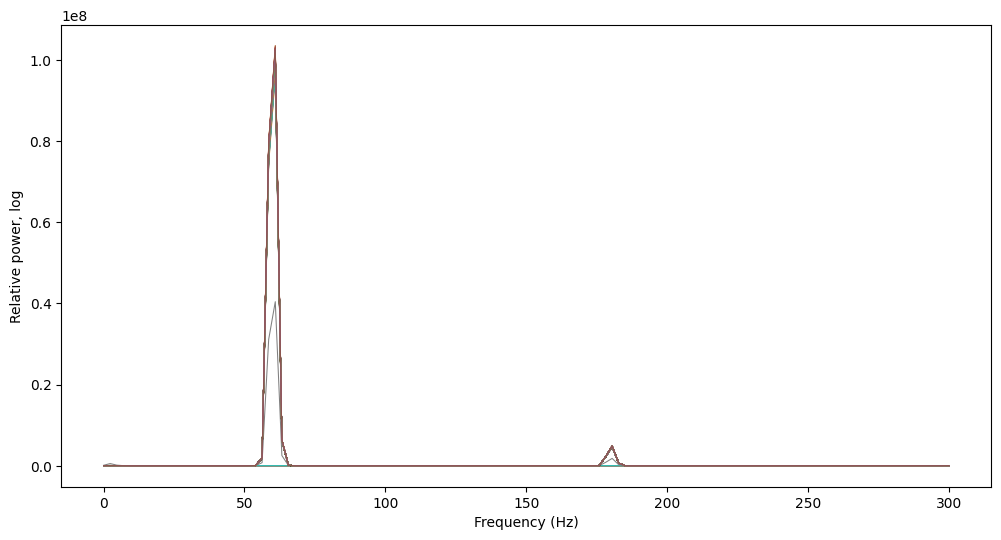

In [5]:
def plot_periodogram(data, sample_rate, log = True):
    for channel in range(data.shape[ 1 ]):
        f, x = signal.welch(data[ :, channel ], fs = sample_rate)
        x = np.log(x) if log else x

        plt.plot(f, x, linewidth = 0.75)

    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Relative power, log')
    plt.show()


plt.figure(figsize = (12, 6))
plot_periodogram(data, sample_rate, log = False)
# Plotting data with no log transformation does not seem very useful,
# and thus will plot with log from now on.

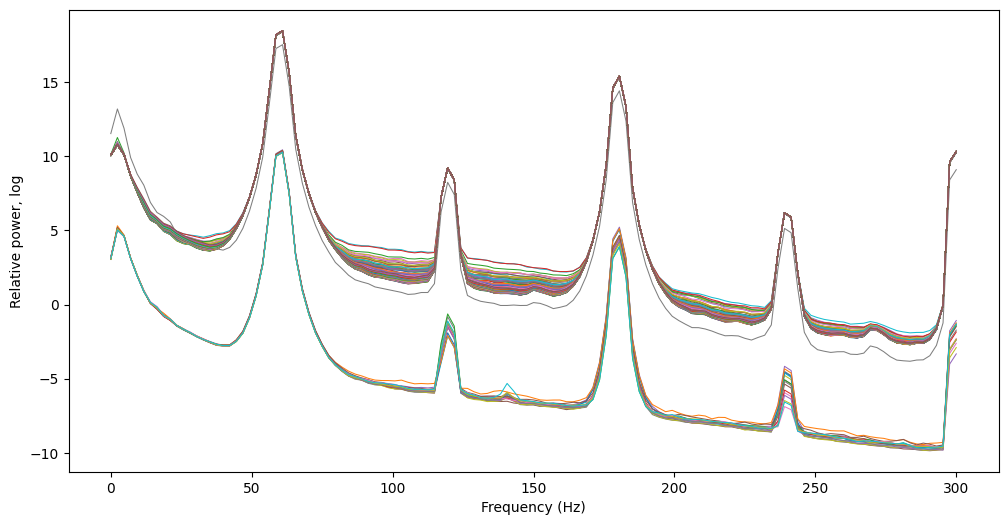

In [6]:
# Same plot, log transformed to display more details
plt.figure(figsize = (12, 6))
plot_periodogram(data, sample_rate)

# Powerline noise at 60 Hz, 120 Hz, 180 Hz...

## Filter your data
Use relevant Scipy functions.

  - If your data contains powerline noise, remove it first.
  - If there is no powerline noise, use a highpass filter with a threshold of your choice to remove slow drifts.

In [7]:
def apply_filter(data, filter):
    filtered_channels = [ ]
    for channel_i in range(data.shape[ 1 ]):
        to_filter = data[ :, channel_i ]
        filtered = signal.sosfiltfilt(filter, to_filter)
        filtered_channels.append(filtered)

    return np.array(filtered_channels).transpose()


def remove_powerline(data, frequencies, sample_rate, range = 1):
    for frequency in frequencies:
        print(f'Removing frequency {frequency}')
        filter = signal.butter(
            N = 20,
            Wn = [ frequency - range, frequency + range ],
            btype = 'bandstop',
            output = 'sos',
            fs = sample_rate
        )

        data = apply_filter(data, filter)

    return data


def low_pass(data, frequency, sample_rate):
    print(f'Passing frequencies lower than {frequency}')

    filter = signal.butter(
        N = 20,
        Wn = frequency,
        btype = 'low',
        output = 'sos',
        fs = sample_rate
    )

    return apply_filter(data, filter)


def high_pass(data, frequency, sample_rate):
    print(f'Passing frequencies higher than {frequency}')

    filter = signal.butter(
        N = 20,
        Wn = frequency,
        btype = 'high',
        output = 'sos',
        fs = sample_rate
    )

    return apply_filter(data, filter)

In [8]:
# Remove powerline noise using notch filter
powerline = [ 60, 120, 180, 240 ]

filtered = remove_powerline(data, powerline, sample_rate, range = 6)
filtered = low_pass(filtered, 290, sample_rate)

Removing frequency 60
Removing frequency 120
Removing frequency 180
Removing frequency 240
Passing frequencies lower than 290


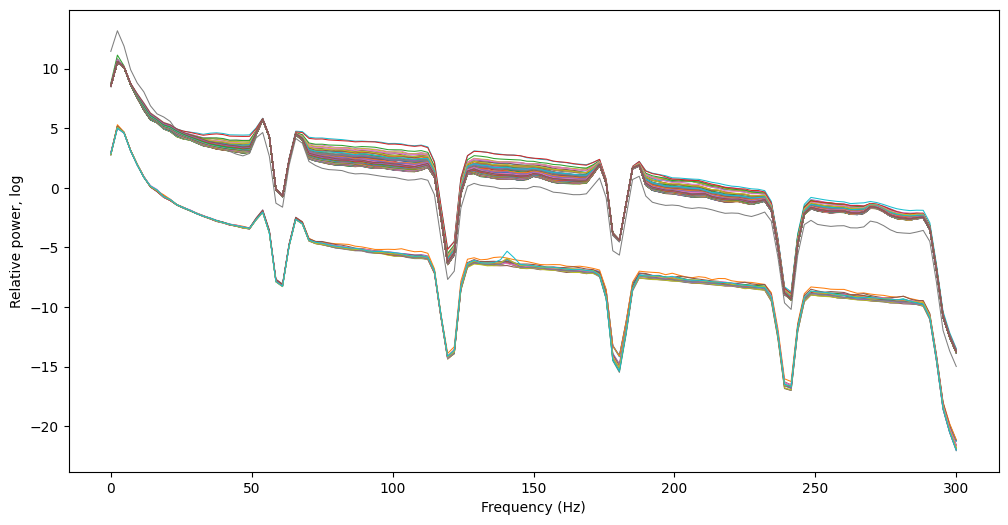

In [9]:
plt.figure(figsize = (12, 6))
plot_periodogram(filtered, sample_rate)

In [10]:
# In the article, they only kept the frequencies in the range [8, 35];
# in my analysis, I want to try to keep a bigger range, maybe that will
# help with the predictor accuracy. If not, will apply more stringent
# filtering later on.

# Will remove frequencies lower than 4 Hz
filtered = high_pass(filtered, 4, sample_rate)

Passing frequencies higher than 4


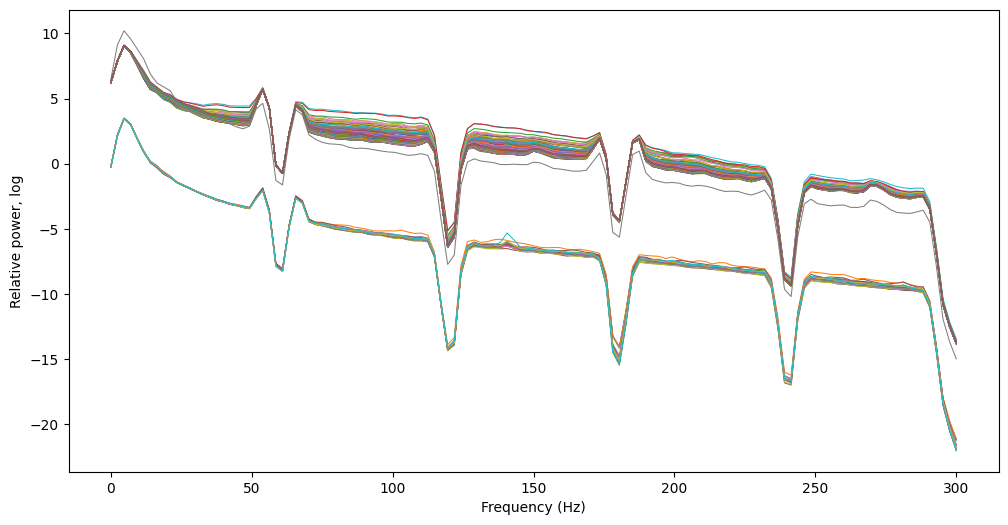

In [11]:
plt.figure(figsize = (12, 6))
plot_periodogram(filtered, sample_rate)

## Visualize filtered data and compare it with the initial data

Compare both periodograms and temporal data.
- E.g. plot both data together on one plot. Don't forget to label which is which (with  a legend).

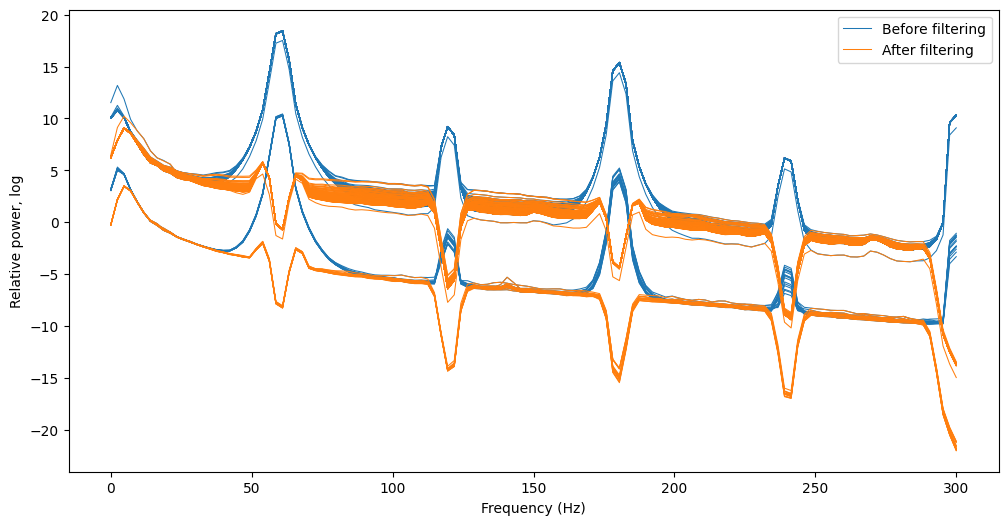

In [12]:
def plot_periodograms(datasets, labels, sample_rate, log = True):
    colors = plt.rcParams[ 'axes.prop_cycle' ].by_key()[ 'color' ][ 0:len(datasets) ]

    for dataset, label, color in zip(datasets, labels, colors):
        has_label = False
        for channel in range(dataset.shape[ 1 ]):
            f, x = signal.welch(dataset[ :, channel ], fs = sample_rate)
            x = np.log(x) if log else x

            if has_label:
                plt.plot(f, x, linewidth = 0.75, color = color)
            else:
                plt.plot(f, x, linewidth = 0.75, color = color, label = label)
                has_label = True

    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Relative power, log')
    plt.legend()
    plt.show()


plt.figure(figsize = (12, 6))
plot_periodograms([ data, filtered ], [ 'Before filtering', 'After filtering' ], sample_rate)

# The filtering removed the power line noise as well as frequencies
# lower than 4 Hz (small dip on the left of the plot) and frequencies
# higher than 290 Hz (which were likely power line as well).
# The power line noise seemed to have quite a wide range in frequency
# (10 Hz or so), so I didn't use the notch filter and instead used the
# butterworth filter to remove a range of frequencies (+- 6 Hz from the
# target powerline).

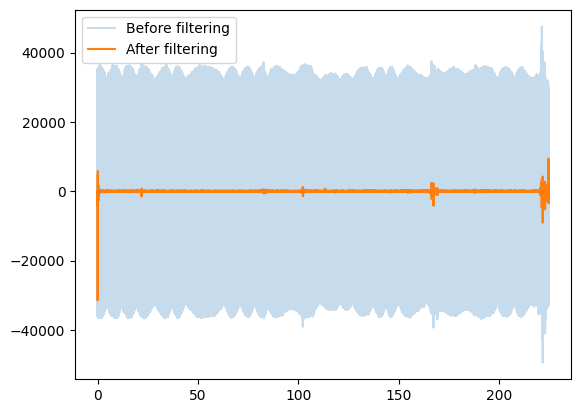

In [13]:
# The difference in signal before and after filtering
colors = plt.rcParams[ 'axes.prop_cycle' ].by_key()[ 'color' ]

plt.plot(timepoints, data[ :, 0 ], colors[ 0 ], alpha = 0.25, label = 'Before filtering')
plt.plot(timepoints, filtered[ :, 0 ], colors[ 1 ], label = 'After filtering')

plt.legend()
plt.show()

Is there any other noise you notice? E.g. heart beat, moving electrodes, etc.?

Inspect the data for any suspicious activity. If you notice anything, visualize it in a separate plot and comment what it can be.

In [14]:
# I don't really see any heartbeat in this data (however it is quite
# difficult to detect visually as there are so many channels).
# Not sure about whether electrode movement is possible in case of g.pangolin,
# they build electrode batches or something of the sort... however, there is
# something strange with the electrode 187 and batch 64-80.

In [15]:
def plot_channels(data, timepoints, time_start, time_end, n_channels = 0, channel_list: list = None, offset = 1.0, y_lab = 'Channel'):
    # Get only the data from time range of interest and only the channels of interest
    # If specific channel list is specified, use channels from the list
    if channel_list is not None and len(channel_list) != 0:
        data = data[ time_start:time_end, channel_list ]
        n_channels = len(channel_list)
        channel_names = channel_list
    else:
        data = data[ time_start:time_end, 0:n_channels ]
        channel_names = list(range(0, data.shape[ 1 ]))

    # Scale the data and add an offset for plotting
    scaled = data / np.max(np.abs(data), axis = 0)
    channel_offset = list(range(0, scaled.shape[ 1 ])) * np.array(offset)
    scaled = scaled + channel_offset

    plt.plot(timepoints[ time_start:time_end ], scaled, color = 'black', linewidth = 0.4)
    plt.yticks(channel_offset, channel_names)
    plt.ylim(-1, offset * n_channels - 1)
    plt.ylabel(y_lab)
    plt.xlabel('Time, s')
    plt.show()


time_start = round(int(np.where(events == 2)[ 0 ][ 0 ]), -3)
time_end = int(time_start + 5e3)

In [16]:
# This plots all channels for visual inspection
# plt.figure(figsize = (15, 256))
# plot_channels(filtered, timepoints, time_start, time_end, 256, offset = 2)

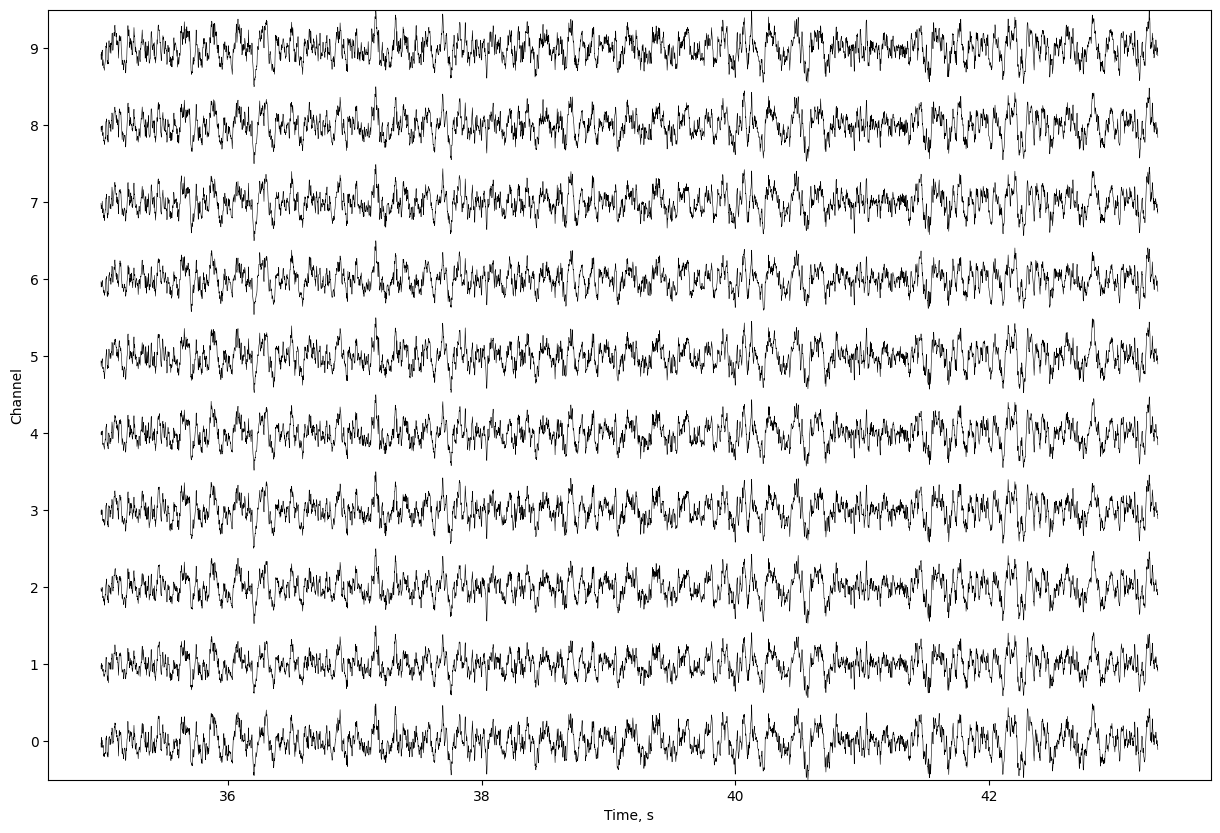

In [17]:
plt.figure(figsize = (15, 10))
plot_channels(filtered, timepoints, time_start, time_end, n_channels = 10, offset = 2)

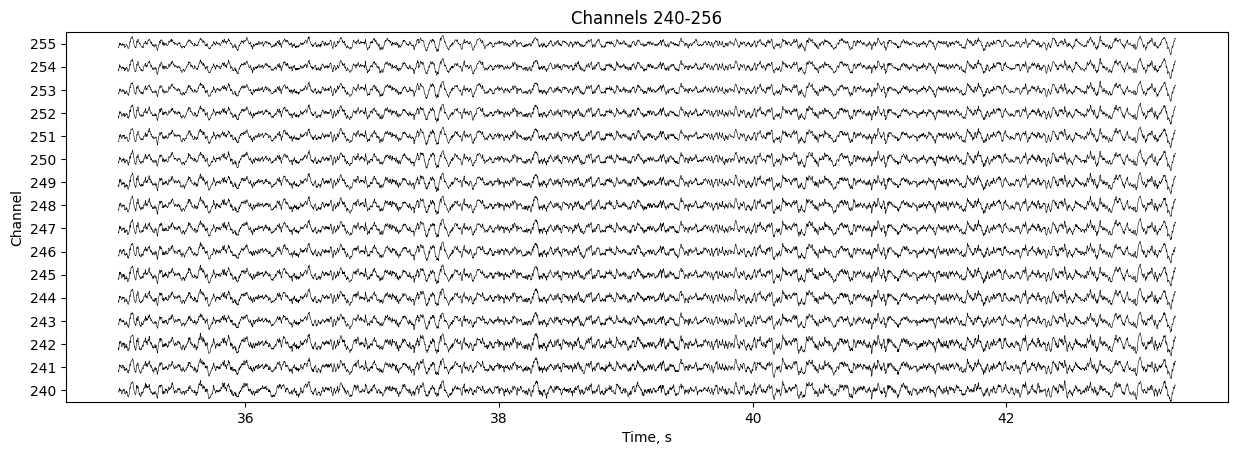

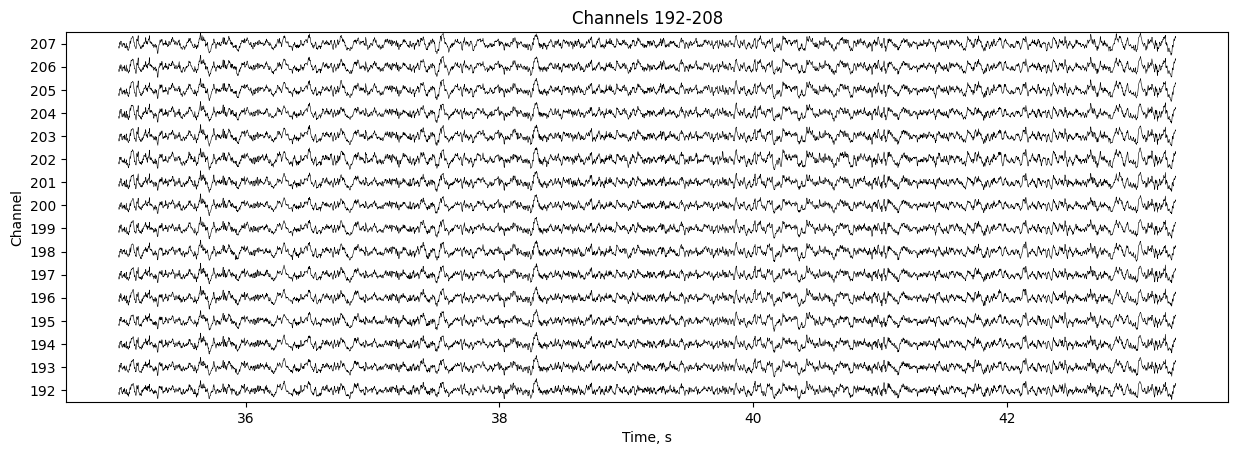

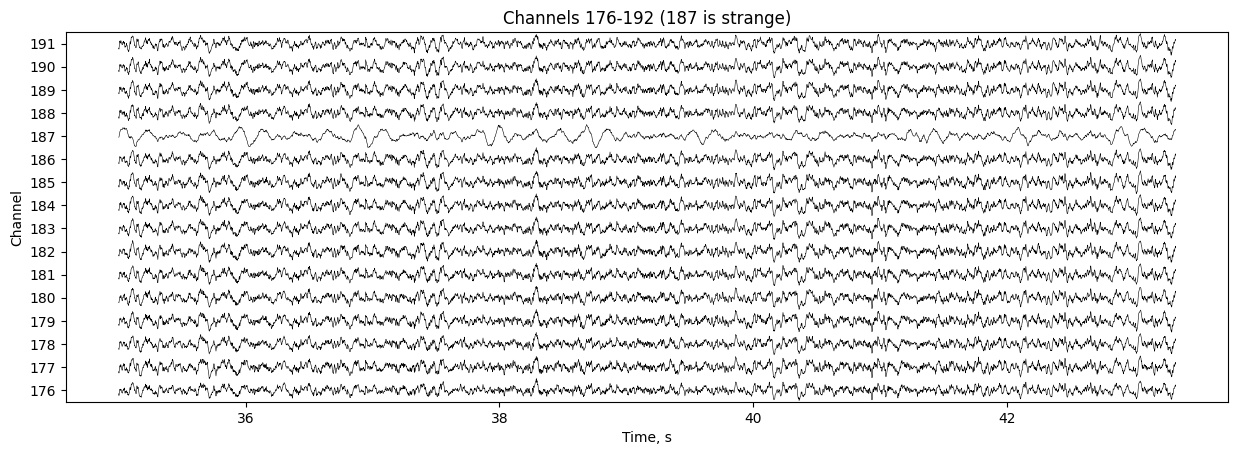

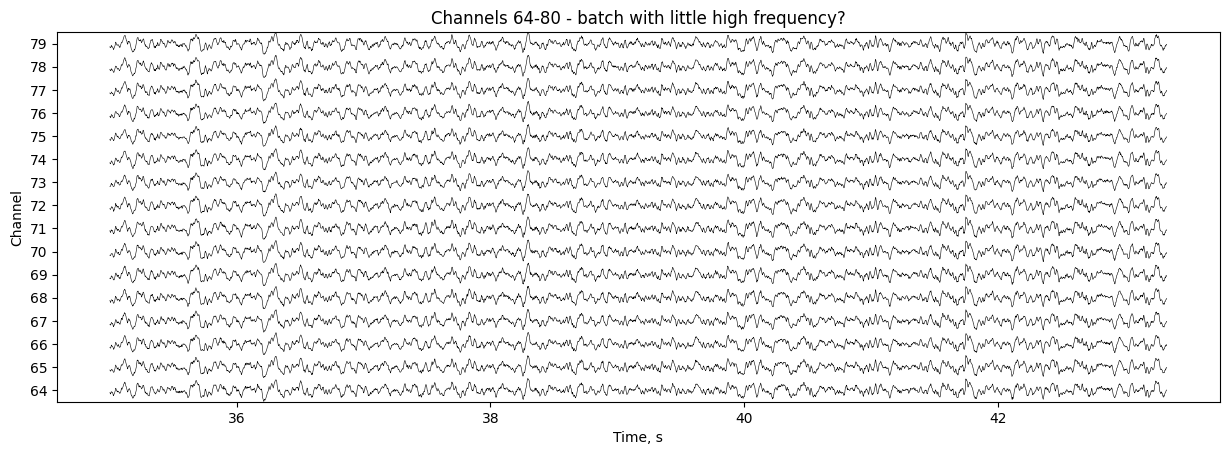

In [18]:
# There seems to be groups of channels that are highly correlated
# (this is more visible with lower low-pass filter, e.g. 40 Hz).
# For example, channels 208-256 differ from channels 192-208.
# Since the number of channels in these two correlated groups are multiples of 16 (48 and 16),
# something tells me that this might be related to the g.pangolin system and the way the
# electrodes are attached.
# I think in this case correlation is good, since they record from the same source and are
# placed very close to each other. It is strange to see such strong correlations between
# electrode "batches". Can they (should they) be removed somehow? It is possible to account
# for batch effects, or maybe select one electrode from a batch?

space_for_one = 0.3

plt.figure(figsize = (15, space_for_one * 16))
plt.title('Channels 240-256')
plot_channels(filtered, timepoints, time_start, time_end, channel_list = list(range(240, 256)), offset = 2)

# plt.figure(figsize = (15, space_for_one * 16))
# plot_channels(filtered, timepoints, time_start, time_end, channel_list = list(range(224, 240)), offset = 2)

# plt.figure(figsize = (15, space_for_one * 16))
# plot_channels(filtered, timepoints, time_start, time_end, channel_list = list(range(208, 224)), offset = 2)

plt.figure(figsize = (15, space_for_one * 16))
plt.title('Channels 192-208')
plot_channels(filtered, timepoints, time_start, time_end, channel_list = list(range(192, 208)), offset = 2)

# The channel 187 is very different from the rest...
plt.figure(figsize = (15, space_for_one * 16))
plt.title('Channels 176-192 (187 is strange)')
plot_channels(filtered, timepoints, time_start, time_end, channel_list = list(range(176, 192)), offset = 2)

# These are a bit strange as well (have less high frequencies?)
plt.figure(figsize = (15, space_for_one * 16))
plt.title('Channels 64-80 - batch with little high frequency?')
plot_channels(filtered, timepoints, time_start, time_end, channel_list = list(range(64, 80)), offset = 2)

## Apply ICA

Use a relevant Scipy function: [FastICA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html).

Visualize the decomposed signals and comment whether a noise you previously noticed is now separated (or not).

In [19]:
transformer = FastICA(n_components = 20, random_state = 42, whiten = 'unit-variance', max_iter = 200)

start_time = datetime.now()

# Reconstruct the signal
sources = transformer.fit_transform(filtered)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:06.811905


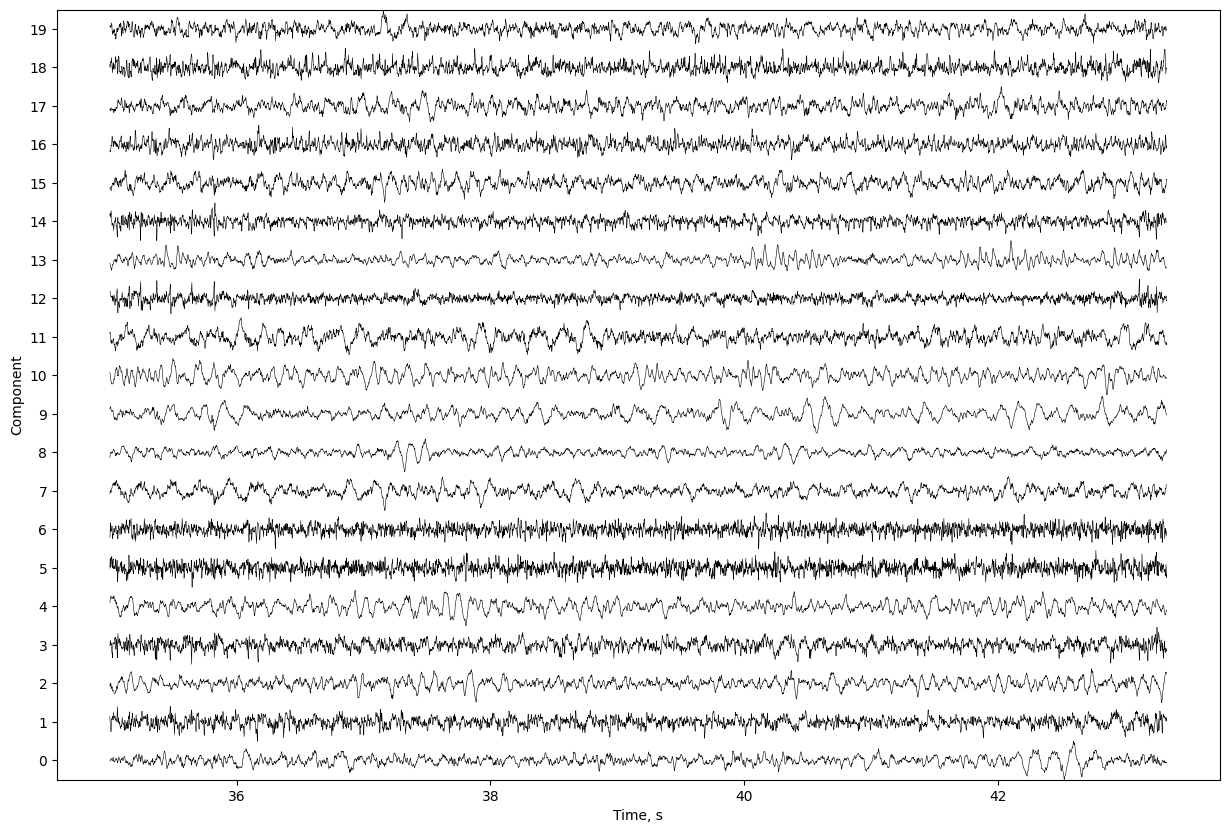

In [20]:
plt.figure(figsize = (15, 10))
plot_channels(sources, timepoints, time_start, time_end, n_channels = 20, offset = 2, y_lab = 'Component')

# Before removing any of the components from the data, we need
# to inspect more closely where they come from (I don't really
# notice any clear artifacts, maybe plotting with mne would help).